In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.path.insert(0, '../methods/')

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARWQE', None)
from ARWQE import *

sys.modules.pop('algo_syn', None)
from algo_syn import *

sys.modules.pop('plots', None)
from plots import *


In [2]:
def simulate(seed, num_periods, true_means, variance, B_arr, B_arr_tr, fixed_windows, train_windows, num_trials, alpha, delta, next_period, rho_values):

    np.random.seed(seed)

    #B_arr is for val set
    B_arr_ends = np.cumsum(B_arr) - 1
    B_arr_tr_ends = np.cumsum(B_arr_tr) - 1

    cdf_array = np.empty((num_trials, len(fixed_windows)+1+len(rho_values), len(train_windows), num_periods))
    interval_array = np.empty((num_trials, len(fixed_windows)+1+len(rho_values), len(train_windows), num_periods))

    seeds = np.arange(num_trials) + 2024

    for (trial, seed) in tqdm(enumerate(seeds)):
        
        np.random.seed(seed)

        X_val = generate_gaussian_sequence(B_arr = B_arr, true_means = true_means, variance=variance)
        X_tr = generate_gaussian_sequence(B_arr = B_arr_tr, true_means = true_means, variance=variance)

        for t in range(num_periods):
            
            idx_tr = B_arr_tr_ends[t]+1
            idx_val = B_arr_ends[t]+1

            mu_hats = np.array(train_synthetic(X_tr[:idx_tr], B_arr_tr[:t+1], train_windows))

            if next_period == True:
                mu_t = true_means[t+1]
            else: 
                mu_t = true_means[t]

            B_arr_t = B_arr[:t+1]

            for m, mu_hat in enumerate(mu_hats):
            #calculate conformity score
                S_t = np.abs(X_val[:idx_val] - mu_hat)
                
                khat, qt_khat, qtk_all = ARWQE(S_t, B_arr_t, alpha, delta)
                coverage_ARW = calculate_coverage(mu_hat, qt_khat, mu_t, variance)

                cdf_array[trial, 0, m, t] = coverage_ARW
                interval_array[trial, 0, m, t] = 2*qt_khat
            
                #baseline: weighted quantile
                for r, rho in enumerate(rho_values):
                    qw = QE_weighted(S_t, B_arr_t, alpha, rho)
                    coverage_w = calculate_coverage(mu_hat, qw, mu_t, variance)
                    cdf_array[trial, 1+r, m, t] = coverage_w
                    interval_array[trial, 1+r, m, t] = 2*qw

                #baseline: take quantile of fixed k
                for ik, k in enumerate(fixed_windows):
                    #qtk = QE_fixed(S_t, B_arr_t, alpha, k)
                    log2k = int(np.log2(k))
                    qtk = qtk_all[min(log2k, len(qtk_all)-1)]
                    coverage_k = calculate_coverage(mu_hat, qtk, mu_t, variance)
                    cdf_array[trial, ik+1+len(rho_values), m, t] = coverage_k
                    interval_array[trial, ik+1+len(rho_values), m, t] = 2*qtk 
                
            
    return cdf_array, interval_array

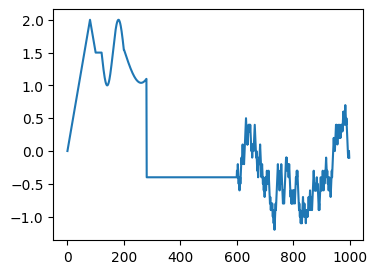

2it [00:29, 14.71s/it]


In [5]:
task = "mean" #mean estimation task

num_trials = 1 #NOTE: change this to run multiple trials

num_periods = 1000
seed = 6
np.random.seed(seed)

B_arr = np.random.randint(low=1, high=10, size=num_periods)

variance = 1
alpha, delta, gamma = 0.1, 0.1, 1

fixed_windows = [1, 4, 16, 64, 256, 1024]
train_windows = [1, 64, 256, 1024]
rho_values = [0.99, 0.9, 0.5, 0.25]

shift = "nonstationary" # "stationary" or "nonstationary"

if shift == "stationary":
    true_means = np.ones(num_periods)
elif shift == "nonstationary":
    true_means = 5 * generate_true_means(num_periods-1, 40, 10)

plt.figure(figsize=(4,3))
plt.plot(true_means)
plt.show()

parameters = {
    "seed": seed,
    "num_periods": num_periods,
    "true_means": true_means,
    "B_arr": B_arr,
    "B_arr_tr": 1 * B_arr,  # This will be calculated based on B_arr
    "fixed_windows": fixed_windows,
    "train_windows": train_windows,
    "num_trials": num_trials,
    "variance": variance, 
    "alpha": alpha, "delta": delta, 
    "next_period": False,
    "rho_values": rho_values
}

cdf_array, interval_array = simulate(**parameters)

In [6]:
np.save(f'./results/{task}_{shift}_cdf_array_rhos.npy', cdf_array, allow_pickle=True)